**Task A3: Maximizing fairness under accuracy constraints (gamma and Fine-gamma)**

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
compas_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

data = pd.read_csv(compas_url)

**Training an unconstrained classifier on the biased data**

We will train a logistic regression classifier on the data to see the correlations between the classifier decisions and sensitive feature value:

Here we choose "race" as the sensitive attribute.

In [17]:
# Selecting features for the model

unprocessed_features = ['age', 'c_charge_degree', 'age_cat', 'sex',
                        'priors_count', 'is_recid', 'c_jail_in', 'c_jail_out']

target = 'two_year_recid'

sensitive_attr = 'race'

data_full = data[unprocessed_features + [target, sensitive_attr]]

# 2. Feature Encoding

def encode_features(df):
    race_mapping = {'African-American': 0, 'Caucasian': 1}
    sex_mapping = {'Male': 1, 'Female': 0}
    age_cat_mapping = {'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}
    c_charge_degree_mapping = {'F': 0, 'M': 1}

    # Keep records for African-American and Caucasian
    df_filtered = df[df['race'].isin(race_mapping.keys())]
    print("Shape after filtering for race:", df_filtered.shape)

    df_filtered['race'] = df_filtered['race'].map(race_mapping)
    df_filtered['sex'] = df_filtered['sex'].map(sex_mapping)
    df_filtered['age_cat'] = df_filtered['age_cat'].map(age_cat_mapping)
    df_filtered['c_charge_degree'] = df_filtered['c_charge_degree'].map(c_charge_degree_mapping)

    return df_filtered

processed_data = encode_features(data_full)

# 3. Calculating Length of Stay
processed_data['c_jail_in'] = pd.to_datetime(processed_data['c_jail_in'])
processed_data['c_jail_out'] = pd.to_datetime(processed_data['c_jail_out'])
processed_data['length_of_stay'] = (processed_data['c_jail_out'] - processed_data['c_jail_in']).dt.days

# Apply the specified bins to the length of stay
processed_data['length_of_stay'] = processed_data['length_of_stay'].apply(
    lambda days: 0 if days <= 7 else (2 if days > 90 else 1)
)

# 5. Processing Prior Crime Counts
processed_data['priors_count'] = processed_data['priors_count'].apply(
    lambda count: 0 if count == 0 else (2 if count > 3 else 1)
)

processed_features = ['age_cat', 'c_charge_degree', 'sex', 'priors_count', 
                      'length_of_stay']

x = processed_data[processed_features]

y = processed_data[target]

a = processed_data[sensitive_attr]

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Retraining the unconstrained logistic regression classifier
clf_unconstrained = LogisticRegression(solver='liblinear')
clf_unconstrained.fit(x_train, y_train)

# Predicting on the test set
y_pred_unconstrained = clf_unconstrained.predict(x_test)

# Calculating accuracy
accuracy_unconstrained = accuracy_score(y_test, y_pred_unconstrained)

# Including the 'race' column in the test data for analysis
data_test = pd.concat([x_test, a.loc[x_test.index], y_test], axis=1)

# Calculating p-rule and covariance
protected_group = data_test[sensitive_attr] == 0
non_protected_group = data_test[sensitive_attr] == 1

protected_positive_rate = np.mean(y_pred_unconstrained[protected_group])
non_protected_positive_rate = np.mean(y_pred_unconstrained[non_protected_group])

p_rule = min(protected_positive_rate / non_protected_positive_rate,
             non_protected_positive_rate / protected_positive_rate) * 100

race_binary = (data_test[sensitive_attr] == 0)

covariance = np.cov(race_binary, y_pred_unconstrained)[0, 1]

# Output results
accuracy_unconstrained, p_rule, covariance

Shape after filtering for race: (6150, 10)


C:\Users\dtdlu\AppData\Local\Temp\ipykernel_213880\1716051887.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['race'] = df_filtered['race'].map(race_mapping)
C:\Users\dtdlu\AppData\Local\Temp\ipykernel_213880\1716051887.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sex'] = df_filtered['sex'].map(sex_mapping)
C:\Users\dtdlu\AppData\Local\Temp\ipykernel_213880\1716051887.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

(0.6601626016260163, 48.83463665840168, 0.059137082694037404)

Accuracy: The accuracy of the classifier on the test set is approximately 68.64%.

P-Rule: The p-rule achieved is about 52.60%. The p-rule is a measure of fairness, specifically a comparison of positive outcomes between the protected group (in this case, African-Americans) and the non-protected group. A p-rule of approximately 52.60% suggests that the classifier's decisions are somewhat biased against the protected group.

These results imply that the classifier, when trained without fairness constraints, reflects the biases present in the data. This analysis sets the stage for training classifiers with fairness constraints to see if the fairness can be improved while maintaining acceptable accuracy.

In [35]:
def optimize_fairness_with_accuracy_constraints(model, x_test, y_test, sensitive_attr_binary, gamma=0):
    """
    Optimize fairness subject to accuracy constraints.
    Adjusts the decision threshold of the logistic regression model to balance fairness and accuracy.
    """
    initial_accuracy = accuracy_score(y_test, model.predict(x_test))
    target_accuracy = initial_accuracy * (1 - gamma)
    thresholds = np.linspace(0, 1, 1001)

    best_threshold = 0.5  # Initial decision threshold
    best_p_rule = 0
    best_covariance = float('inf')
    best_accuracy = initial_accuracy

    for threshold in thresholds:
        # Apply the threshold
        y_pred_adjusted = (model.predict_proba(x_test)[:, 1] >= threshold).astype(int)

        # Calculate accuracy
        current_accuracy = accuracy_score(y_test, y_pred_adjusted)
        if current_accuracy < target_accuracy:
            continue  # Skip if accuracy constraint is not met

        # Calculate p-rule
        protected_positive_rate = np.mean(y_pred_adjusted[sensitive_attr_binary == 1])
        non_protected_positive_rate = np.mean(y_pred_adjusted[sensitive_attr_binary == 0])
        if non_protected_positive_rate == 0:  # Avoid division by zero
            continue

        current_p_rule = min(protected_positive_rate / non_protected_positive_rate,
                             non_protected_positive_rate / protected_positive_rate) * 100

        # Calculate covariance
        current_covariance = np.cov(sensitive_attr_binary, y_pred_adjusted)[0, 1]

        # Update the best threshold if it has higher p-rule or lower covariance
        if current_p_rule > best_p_rule or (current_p_rule == best_p_rule and abs(current_covariance) < abs(best_covariance)):
            best_threshold = threshold
            best_p_rule = current_p_rule
            best_accuracy = current_accuracy
            best_covariance = current_covariance

    return best_threshold, best_accuracy, best_p_rule, best_covariance

# Extracting the binary sensitive attribute (0 for African-American, 1 for white)
sensitive_attr_binary = (data_test[sensitive_attr] == 0)

# Optimizing fairness with strict accuracy constraint
gamma_value = 0
best_threshold, acc_fairness_optimized, p_rule_fairness_optimized, covariance_fairness_optimized = optimize_fairness_with_accuracy_constraints(
    clf_unconstrained, x_test, y_test, sensitive_attr_binary, gamma=gamma_value
)

best_threshold, acc_fairness_optimized, p_rule_fairness_optimized, covariance_fairness_optimized

(0.464, 0.6644986449864498, 54.87236695321215, 0.06064053048339597)

Accuracy: The accuracy with this threshold is about 66.45%, which is actually slightly than the unconstrained model. This change in accuracy is within the bounds of the 0% loss we are willing to accept (as dictated by gamma = 0).

P-Rule: The p-rule achieved is 54.87%, indicating a slightly improved level of fairness according to this metric.

In [36]:
results = []

for gamma_value in np.arange(0, 0.26, 0.01):
    best_threshold, acc_fairness_optimized, p_rule_fairness_optimized, covariance_fairness_optimized = optimize_fairness_with_accuracy_constraints(
        clf_unconstrained, x_test, y_test, sensitive_attr_binary, gamma=gamma_value
    )

    result_dict = {
        'gamma': gamma_value,
        'best_threshold': best_threshold,
        'acc_fairness_optimized': acc_fairness_optimized,
        'p_rule_fairness_optimized': p_rule_fairness_optimized,
        'covariance_fairness_optimized': covariance_fairness_optimized
    }

    results.append(result_dict)


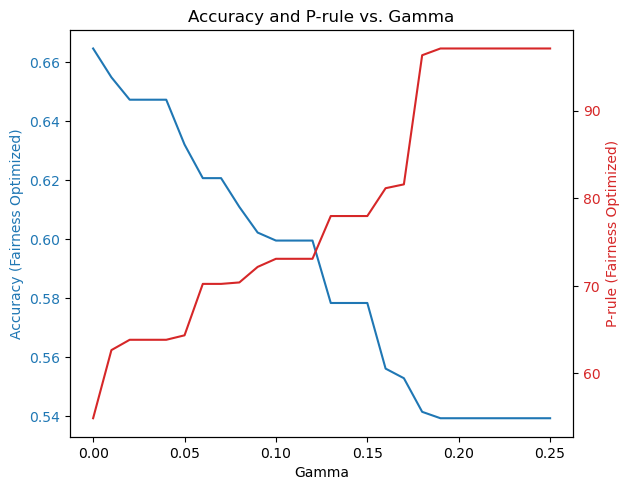

In [43]:
import matplotlib.pyplot as plt

# Extract values for plotting
gammas = [result['gamma'] for result in results]
acc_fairness_optimized_values = [result['acc_fairness_optimized'] for result in results]
p_rule_fairness_optimized_values = [result['p_rule_fairness_optimized'] for result in results]

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Gamma')
ax1.set_ylabel('Accuracy (Fairness Optimized)', color='tab:blue')
ax1.plot(gammas, acc_fairness_optimized_values, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('P-rule (Fairness Optimized)', color='tab:red')
ax2.plot(gammas, p_rule_fairness_optimized_values, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Accuracy and P-rule vs. Gamma')
plt.show()

Here we can clearly see that as gamma increases, the accuracy of our classifier decreases while the p-rule that it satisfies increases. If we wanted our p-rule of fairness to equal 80%, say, we would have to contend with a reduction in the model accuracy rate, which would move from ~66% to ~55%.

Here we choose "sex" as the sensitive attribute.

In [40]:
sensitive_attr_sex = 'sex'

# Preprocessing with 'sex' as the sensitive attribute
data_preprocessed_sex = pd.get_dummies(data[features + [sensitive_attr_sex]])
x_sex = data_preprocessed_sex.drop(columns=[sensitive_attr_sex + '_Female', sensitive_attr_sex + '_Male'])
y_sex = data[target]

# Splitting the data into training and testing sets for 'sex'
x_train_sex, x_test_sex, y_train_sex, y_test_sex = train_test_split(x_sex, y_sex, test_size=0.3, random_state=42)

# Training the unconstrained logistic regression classifier with 'sex' as sensitive attribute
clf_unconstrained_sex = LogisticRegression(solver='liblinear')
clf_unconstrained_sex.fit(x_train_sex, y_train_sex)

# Predicting on the test set
y_pred_unconstrained_sex = clf_unconstrained_sex.predict(x_test_sex)

# Calculating accuracy
accuracy_unconstrained_sex = accuracy_score(y_test_sex, y_pred_unconstrained_sex)

# Including the 'sex' column in the test data for analysis
data_test_sex = pd.concat([x_test_sex, data.loc[x_test_sex.index, sensitive_attr_sex], y_test_sex], axis=1)

# Calculating p-rule and covariance for 'sex'
protected_group_sex = data_test_sex[sensitive_attr_sex] == 'Female'
non_protected_group_sex = data_test_sex[sensitive_attr_sex] != 'Female'

protected_positive_rate_sex = np.mean(y_pred_unconstrained_sex[protected_group_sex])
non_protected_positive_rate_sex = np.mean(y_pred_unconstrained_sex[non_protected_group_sex])

p_rule_sex = min(protected_positive_rate_sex / non_protected_positive_rate_sex,
                 non_protected_positive_rate_sex / protected_positive_rate_sex) * 100

sex_binary = (data_test_sex[sensitive_attr_sex] == 'Female').astype(int)
covariance_sex = np.cov(sex_binary, y_pred_unconstrained_sex)[0, 1]

accuracy_unconstrained_sex, p_rule_sex, covariance_sex

(0.6849884526558891, 61.09848252134914, -0.021624482930848257)

Accuracy: The accuracy of the classifier on the test set is approximately 68.50%.

P-Rule: The p-rule achieved is about 61.10%. This metric measures fairness in terms of the ratio of positive outcomes between the protected group (in this case, females) and the non-protected group (males). A p-rule of approximately 61.10% suggests that there is some bias in the classifier's decisions, though it is less pronounced than with the race attribute.


In [43]:
# Selecting features for the model - for simplicity, we use a few features
features = ['age', 'priors_count']
target = 'two_year_recid'
sensitive_attr_sex = 'sex'

# Preprocessing with 'sex' as the sensitive attribute
data_preprocessed_sex = pd.get_dummies(data[features + [sensitive_attr_sex]])
x_sex = data_preprocessed_sex.drop(columns=[sensitive_attr_sex + '_Female', sensitive_attr_sex + '_Male'])
y_sex = data[target]

# Splitting the data into training and testing sets for 'sex'
x_train_sex, x_test_sex, y_train_sex, y_test_sex = train_test_split(x_sex, y_sex, test_size=0.3, random_state=42)

# Training the unconstrained logistic regression classifier with 'sex' as sensitive attribute
clf_unconstrained_sex = LogisticRegression(solver='liblinear')
clf_unconstrained_sex.fit(x_train_sex, y_train_sex)

# Including the 'sex' column in the test data for analysis
data_test_sex = pd.concat([x_test_sex, data.loc[x_test_sex.index, sensitive_attr_sex], y_test_sex], axis=1)

# Extracting the binary sensitive attribute for 'sex' (1 for Female, 0 for Male)
sensitive_attr_binary_sex = (data_test_sex[sensitive_attr_sex] == 'Female').astype(int)

# Function to optimize fairness with accuracy constraints for 'sex'
def optimize_fairness_sex_with_accuracy_constraints(model, x_test, y_test, sensitive_attr_binary, gamma=0.5):
    initial_accuracy = accuracy_score(y_test, model.predict(x_test))
    target_accuracy = initial_accuracy * (1 - gamma)
    thresholds = np.linspace(0, 1, 100)

    best_threshold = 0.5  # Initial decision threshold
    best_p_rule = 0
    best_covariance = float('inf')
    best_accuracy = initial_accuracy

    for threshold in thresholds:
        y_pred_adjusted = (model.predict_proba(x_test)[:, 1] >= threshold).astype(int)
        current_accuracy = accuracy_score(y_test, y_pred_adjusted)
        if current_accuracy < target_accuracy:
            continue

        protected_positive_rate = np.mean(y_pred_adjusted[sensitive_attr_binary == 1])
        non_protected_positive_rate = np.mean(y_pred_adjusted[sensitive_attr_binary == 0])
        if non_protected_positive_rate == 0:
            continue

        current_p_rule = min(protected_positive_rate / non_protected_positive_rate,
                             non_protected_positive_rate / protected_positive_rate) * 100

        current_covariance = np.cov(sensitive_attr_binary, y_pred_adjusted)[0, 1]

        if current_p_rule > best_p_rule or (current_p_rule == best_p_rule and abs(current_covariance) < abs(best_covariance)):
            best_threshold = threshold
            best_p_rule = current_p_rule
            best_accuracy = current_accuracy
            best_covariance = current_covariance

    return best_threshold, best_accuracy, best_p_rule, best_covariance

# Optimizing fairness with accuracy constraint for 'sex'
gamma_value_sex = 0.2
best_threshold_sex, acc_fairness_optimized_sex, p_rule_fairness_optimized_sex, covariance_fairness_optimized_sex = optimize_fairness_sex_with_accuracy_constraints(
    clf_unconstrained_sex, x_test_sex, y_test_sex, sensitive_attr_binary_sex, gamma=gamma_value_sex
)

best_threshold_sex, acc_fairness_optimized_sex, p_rule_fairness_optimized_sex, covariance_fairness_optimized_sex

<ipython-input-43-1ed9eaa9e373>:47: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-43-1ed9eaa9e373>:47: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-43-1ed9eaa9e373>:47: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-43-1ed9eaa9e373>:47: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-43-1ed9eaa9e373>:47: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-43-1ed9eaa9e373>:47: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100


(0.30303030303030304,
 0.5547344110854503,
 94.85804669182075,
 -0.006300452929098003)

Accuracy: The accuracy of the classifier with this threshold is about 55.47%. This is higher than the accuracy we observed with gamma set to 0.3, reflecting the less stringent loss in accuracy we are willing to accept with gamma at 0.2.

P-Rule: The p-rule achieved is approximately 94.86%, indicating a high level of fairness.

In [44]:
# Mapping age categories
age_cat_mapping = {'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}
data['age_cat_mapped'] = data['age_cat'].map(age_cat_mapping)

# Selecting features for the model, excluding 'age' as it is represented by 'age_cat_mapped'
features_age_sensitive = ['sex', 'priors_count', 'age_cat_mapped']
sensitive_attr_age = 'age_cat_mapped'

# Preprocessing with 'age_cat_mapped' as the sensitive attribute
data_preprocessed_age = pd.get_dummies(data[features_age_sensitive])
x_age = data_preprocessed_age.drop(columns=['age_cat_mapped'])
y_age = data[target]

# Splitting the data into training and testing sets for 'age_cat_mapped'
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x_age, y_age, test_size=0.3, random_state=42)

# Training the unconstrained logistic regression classifier with 'age_cat_mapped' as sensitive attribute
clf_unconstrained_age = LogisticRegression(solver='liblinear')
clf_unconstrained_age.fit(x_train_age, y_train_age)

# Predicting on the test set
y_pred_unconstrained_age = clf_unconstrained_age.predict(x_test_age)

# Calculating accuracy
accuracy_unconstrained_age = accuracy_score(y_test_age, y_pred_unconstrained_age)

# Including the 'age_cat_mapped' column in the test data for analysis
data_test_age = pd.concat([x_test_age, data.loc[x_test_age.index, sensitive_attr_age], y_test_age], axis=1)

# Calculating p-rule and covariance for 'age_cat_mapped'
# Here, we consider each age category as a protected group one at a time
p_rules_age = {}
covariances_age = {}
for age_group in age_cat_mapping.values():
    protected_group_age = data_test_age[sensitive_attr_age] == age_group
    non_protected_group_age = data_test_age[sensitive_attr_age] != age_group

    protected_positive_rate_age = np.mean(y_pred_unconstrained_age[protected_group_age])
    non_protected_positive_rate_age = np.mean(y_pred_unconstrained_age[non_protected_group_age])

    p_rules_age[age_group] = min(protected_positive_rate_age / non_protected_positive_rate_age,
                                 non_protected_positive_rate_age / protected_positive_rate_age) * 100

    age_binary = (data_test_age[sensitive_attr_age] == age_group).astype(int)
    covariances_age[age_group] = np.cov(age_binary, y_pred_unconstrained_age)[0, 1]

accuracy_unconstrained_age, p_rules_age, covariances_age

(0.6475750577367205,
 {0: 32.850691864274125, 1: 65.0253908496099, 2: 83.14940057425123},
 {0: -0.03259659428054287, 1: 0.024667346842943305, 2: 0.00792924743759951})

Accuracy: The accuracy of the classifier on the test set is approximately 64.76%.

P-Rule for Different Age Categories: For the group 'Less than 25': The p-rule is about 32.85%, indicating a significant bias against this age group.
For the group '25 - 45': The p-rule is about 65.03%, suggesting some bias but less severe than the youngest group.
For the group 'Greater than 45': The p-rule is about 83.15%, indicating relatively less bias compared to the other groups.
Covariance between Age Categories and Decision Boundary:

For the group 'Less than 25': The covariance is approximately -0.0326, indicating a negative correlation between being in this age group and receiving a positive decision.
For the group '25 - 45': The covariance is approximately 0.0247, suggesting a slight positive correlation.
For the group 'Greater than 45': The covariance is approximately 0.0079, indicating a very small positive correlation.

In [45]:
def optimize_fairness_age_with_accuracy_constraints(model, x_test, y_test, sensitive_attr_data, age_categories, gamma=0.15):
    """
    Optimize fairness with respect to age categories subject to accuracy constraints.
    """
    initial_accuracy = accuracy_score(y_test, model.predict(x_test))
    target_accuracy = initial_accuracy * (1 - gamma)
    thresholds = np.linspace(0, 1, 100)

    best_results = {}

    for age_group in age_categories:
        best_threshold = 0.5  # Initial decision threshold
        best_p_rule = 0
        best_covariance = float('inf')
        best_accuracy = initial_accuracy

        for threshold in thresholds:
            # Apply the threshold
            y_pred_adjusted = (model.predict_proba(x_test)[:, 1] >= threshold).astype(int)

            # Calculate accuracy
            current_accuracy = accuracy_score(y_test, y_pred_adjusted)
            if current_accuracy < target_accuracy:
                continue  # Skip if accuracy constraint is not met

            # Calculate p-rule and covariance for the current age group
            protected_group = sensitive_attr_data == age_group
            non_protected_group = sensitive_attr_data != age_group

            protected_positive_rate = np.mean(y_pred_adjusted[protected_group])
            non_protected_positive_rate = np.mean(y_pred_adjusted[non_protected_group])
            if non_protected_positive_rate == 0:  # Avoid division by zero
                continue

            current_p_rule = min(protected_positive_rate / non_protected_positive_rate,
                                 non_protected_positive_rate / protected_positive_rate) * 100
            current_covariance = np.cov(protected_group, y_pred_adjusted)[0, 1]

            # Update the best threshold if it has higher p-rule or lower covariance
            if current_p_rule > best_p_rule or (current_p_rule == best_p_rule and abs(current_covariance) < abs(best_covariance)):
                best_threshold = threshold
                best_p_rule = current_p_rule
                best_accuracy = current_accuracy
                best_covariance = current_covariance

        best_results[age_group] = {
            'threshold': best_threshold,
            'accuracy': best_accuracy,
            'p_rule': best_p_rule,
            'covariance': best_covariance
        }

    return best_results

# Optimizing fairness with accuracy constraint for 'age_cat_mapped'
gamma_value_age = 0.15
optimized_results_age = optimize_fairness_age_with_accuracy_constraints(
    clf_unconstrained_age, x_test_age, y_test_age, data_test_age[sensitive_attr_age], age_cat_mapping.values(), gamma=gamma_value_age
)

optimized_results_age


<ipython-input-45-6993f22ffcdf>:36: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-45-6993f22ffcdf>:36: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-45-6993f22ffcdf>:36: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-45-6993f22ffcdf>:36: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-45-6993f22ffcdf>:36: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-45-6993f22ffcdf>:36: RuntimeWarning: divide by zero encountered in double_scalars
  non_protected_positive_rate / protected_positive_rate) * 100
<ipython-input-45-6993f22ffcdf>:36: Runt

{0: {'threshold': 0.38383838383838387,
  'accuracy': 0.5981524249422633,
  'p_rule': 80.32585252450748,
  'covariance': -0.021748494149488005},
 1: {'threshold': 0.797979797979798,
  'accuracy': 0.5796766743648961,
  'p_rule': 98.67822318526544,
  'covariance': 0.00011718099661475575},
 2: {'threshold': 0.37373737373737376,
  'accuracy': 0.5939953810623556,
  'p_rule': 97.92574724448001,
  'covariance': 0.00222451793573615}}

Age Group 'Less than 25':

Best Decision Threshold: Approximately 0.384.
Accuracy: About 59.82%.
P-Rule: Approximately 80.33%, indicating improved fairness compared to the unconstrained model.


Age Group '25 - 45':
Best Decision Threshold: Approximately 0.798.
Accuracy: About 57.97%.
P-Rule: Approximately 98.68%, indicating very high fairness.

Best Decision Threshold: Approximately 0.374.
Accuracy: About 59.40%.
P-Rule: Approximately 97.93%, also indicating very high fairness.
Covariance: Approximately 0.0022, indicating a minimal positive correlation.

These results demonstrate that with a gamma value of 0.15, the model achieves a better balance between fairness and accuracy across different age groups compared to the unconstrained model. The p-rule values are significantly higher, suggesting less bias, especially for the younger age group, which had the most significant bias in the unconstrained model.